<a href="https://colab.research.google.com/github/Metallicode/Math/blob/main/RNN_on_a_Sine_Wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RNN on a Sine Wave

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
t = np.linspace(0, 50, 501)
y = np.sin(t)

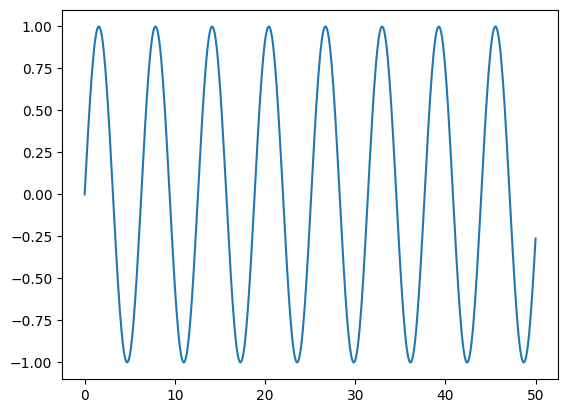

In [3]:
plt.plot(t, y)

In [4]:
df = pd.DataFrame(index=t, data=y, columns=['Sine'])

In [5]:
len(df)

501

##Train Test Split

In [6]:
test_percent = 0.1
test_point = np.round(len(df)* test_percent)

In [7]:
test_point

50.0

In [8]:
test_index = int(len(df)-test_point)

In [9]:
test_index

451

In [10]:
train = df.iloc[:test_index]
len(train)

451

In [11]:
test = df.iloc[test_index:]
len(test)

50

##Scale Train AND Test Set

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaler.fit(train)

MinMaxScaler()

In [15]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

##TimeseriesGenerator

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
length = 50     #n points we give the model             [0,1,2,3,4,5,6,7,8,9]
batch_size = 1  #n points we want the model to return                        [10]

In [18]:
generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train,
                                length=length,batch_size=batch_size)

In [ ]:
#help(TimeseriesGenerator)

##Using SimpleRNN

###understanding generator object

In [ ]:
X, y = generator[0]

In [ ]:
X #we see that X's length is same as our length var

In [ ]:
y #we see that y's length is same as our batch_size var

In [ ]:
train_set[:length+batch_size] #here we can see the original data from our train_set

###Create and train the model

In [19]:
from tensorflow.keras.models import Sequential

In [20]:
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense

In [21]:
n_features = 1

In [ ]:
##help(SimpleRNN)

In [22]:
model = Sequential()

model.add(SimpleRNN(units=length, input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model.fit_generator(generator, epochs=5) #`Model.fit_generator` is deprecated

Epoch 1/5


<ipython-input-24-a45296059e88>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=5) #`Model.fit_generator` is deprecated


401/401 [==============================] - 6s 12ms/step - loss: 0.0042
Epoch 2/5
401/401 [==============================] - 3s 7ms/step - loss: 4.1920e-04
Epoch 3/5
401/401 [==============================] - 3s 8ms/step - loss: 5.8775e-05
Epoch 4/5
401/401 [==============================] - 3s 7ms/step - loss: 6.3727e-05
Epoch 5/5
401/401 [==============================] - 3s 7ms/step - loss: 6.1036e-04


In [25]:
losses = pd.DataFrame(model.history.history)

<Axes: >

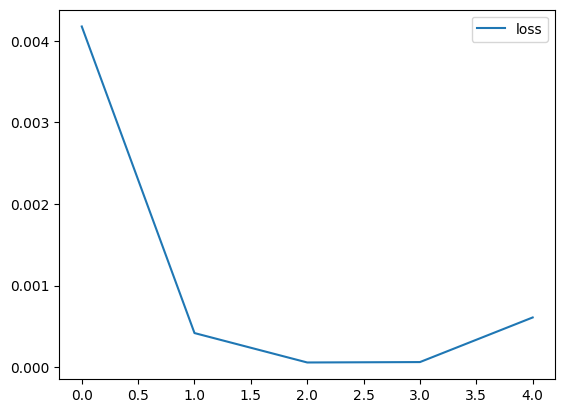

In [26]:
losses.plot()

###Predict

In [ ]:
length

50

In [ ]:
batch = scaled_train[-length:]
batch.shape

(50, 1)

In [ ]:
batch = batch.reshape((1,length,n_features))
batch.shape

(1, 50, 1)

In [ ]:
model.predict(batch)

1/1 [==============================] - 0s 142ms/step


array([[0.9227132]], dtype=float32)

In [ ]:
scaled_train[0]

array([0.94955134])

###Predict full test range

In [27]:
test_preds = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_preds.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 34ms/step


In [ ]:
test_preds

###Inverse Transform Scale

In [29]:
true_preds = scaler.inverse_transform(test_preds)

###plot test Vs preds

In [32]:
test['preds'] = true_preds

<ipython-input-32-b8f0b3b887ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['preds'] = true_preds


<Axes: >

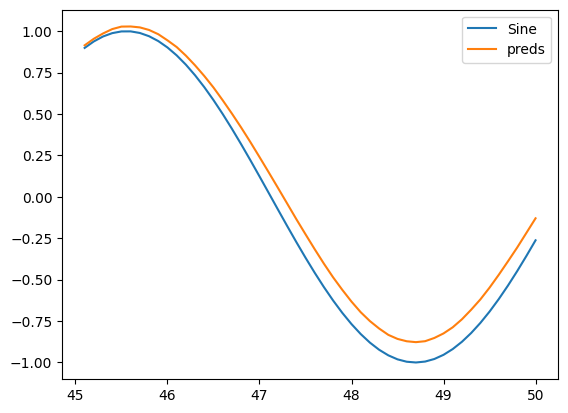

In [33]:
test.plot()

##Using LSTM

###Use Early Stopping Callback

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
early_stop = EarlyStopping(monitor="val_loss", patience=2)

###Create validation Timeseries Generator

if our validation sets length is the same as the TimeseriesGenerators length we will get this error:


*ValueError: `start_index+length=50 > end_index=49` is disallowed, as no part of the sequence would be left to be used as current step.*

In [36]:
length = 49

train_generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train,
                                           length=length,batch_size=batch_size)

validation_generator = TimeseriesGenerator(data=scaled_test, targets=scaled_test,
                                           length=length,batch_size=batch_size)

###Create The LSTM Model

In [37]:
lstm_model = Sequential()

lstm_model.add(LSTM(units=length, input_shape=(length,n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

###Fit LSTM Model

In [38]:
lstm_model.fit_generator(train_generator, epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20


<ipython-input-38-bad0058d36fb>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  lstm_model.fit_generator(train_generator, epochs=20,


402/402 [==============================] - 11s 20ms/step - loss: 0.0167 - val_loss: 4.1993e-08
Epoch 2/20
402/402 [==============================] - 8s 20ms/step - loss: 1.0308e-04 - val_loss: 6.8748e-05
Epoch 3/20
402/402 [==============================] - 7s 17ms/step - loss: 9.7472e-05 - val_loss: 2.2411e-05


###Predict

In [43]:
test_preds = []

first_batch = scaled_train[-length:]
current_batch_reshaped = first_batch.reshape((1, length, n_features))

for i in range(len(scaled_test)):
  current_pred = lstm_model.predict(current_batch_reshaped)[0]
  test_preds.append(current_pred)
  current_batch_reshaped = np.append(current_batch_reshaped[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 51ms/step


###Inverse Transform predictions

In [44]:
true_preds = scaler.inverse_transform(test_preds)

###Plot Predictions

In [45]:
test['LSTM preds'] = true_preds

<ipython-input-45-cc41500ab3f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM preds'] = true_preds


<Axes: >

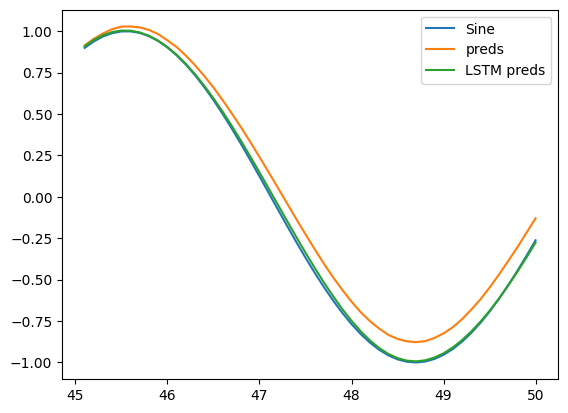

In [46]:
test.plot()

##Forcasting

###we will use all our data for this i.e no train/test split

In [47]:
full_scaler = MinMaxScaler()

In [48]:
full_scaler.fit(df)

MinMaxScaler()

In [49]:
all_data = full_scaler.transform(df)

In [50]:
length = 50 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(all_data, all_data, length=length, batch_size=1)

###Create model

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=6)

In [ ]:
forecast = []

first_eval_batch = all_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    forecast.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [53]:
forecast = scaler.inverse_transform(forecast)

In [54]:
forecast_index = np.arange(50.1,55.1,step=0.1)

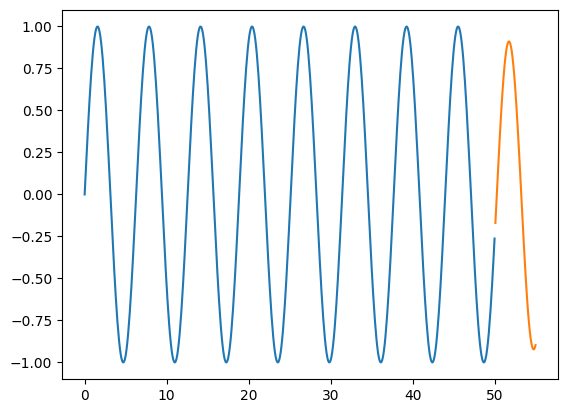

In [55]:
plt.plot(df.index,df['Sine'])
plt.plot(forecast_index,forecast)